## Train Infection Classifier

In the previous lessons we have built a method for cell instance segmentation and applied it to our dataset. Now we turn to classifying the cells into infected vs. non-infected cells, based on the virus marker channel, nucleus image channel and segmentation mask for each individual cell. We will use a ResNet for this task.

The goal of this lesson is to learn how to train a classification model with `torch_em`.

# adapt to new structure and optimize code

In [1]:
# General imports.

import os 
import napari
import glob
from shutil import move
import imageio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch
from skimage import measure
from skimage.measure import regionprops
from scipy.ndimage import zoom
import math
import requests
import json
import random
import numpy as np
import numpy.ma as ma
from pprint import pprint
from tqdm import tqdm
import sys

sys.path.append("..")
import utils

In [2]:
# download and extract data, then convert data into .tif
# check if data preparation might have already happended, then do not repeat
src = "./"
dst_dir = "data"
if not os.path.exists(os.path.join(src, os.path.join(dst_dir, "train"))):
    utils.prepare_data()

Download https://zenodo.org/record/5092850/files/covid-if-groundtruth.zip?download=1 to data/data.zip: 100%|██████████| 491M/491M [00:57<00:00, 8.99MB/s] 
100%|██████████| 49/49 [00:21<00:00,  2.29it/s]


We have 35 training images in data/train
We have 5 validation images in data/val
We have 9 test images in data/test


In [3]:
# get data directories and show content of one image folder 
data_dir = "data"
data_dirs = {
    "train": os.path.join(data_dir, "train"),
    "val": os.path.join(data_dir, "val"),
    "test": os.path.join(data_dir, "test")
}

print(os.listdir(os.path.join(data_dirs["train"], "gt_image_000")))

['gt_image_000_nucleus_image.tif', 'labels.json', 'gt_image_000_marker_image.tif', 'gt_image_000_infected_labels.tif', 'gt_image_000_nucleus_labels.tif', 'gt_image_000_cell_labels.tif', 'gt_image_000_serum_image.tif']


In [4]:
def get_file_paths(root_dir, of_type):
    tifs = []

    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.endswith(of_type):
                tifs.append(os.path.join(dirpath, filename))

    return tifs

tif_file_paths = {}
json_file_paths = {}
for key, value in data_dirs.items():
    tif_file_paths[key] = get_file_paths(data_dirs[key], ".tif")
    json_file_paths[key] = get_file_paths(data_dirs[key], ".json")
    json_file_paths[key].sort()
print(tif_file_paths["train"][0:6])

['data/train/gt_image_028/gt_image_028_nucleus_labels.tif', 'data/train/gt_image_028/gt_image_028_infected_labels.tif', 'data/train/gt_image_028/gt_image_028_serum_image.tif', 'data/train/gt_image_028/gt_image_028_marker_image.tif', 'data/train/gt_image_028/gt_image_028_nucleus_image.tif', 'data/train/gt_image_028/gt_image_028_cell_labels.tif']


### 1. Inspect Training Data

First, we visually check all the relevant training data. We will use it to construct image patches for training the classification model as follows:
- Compute the bounding box around each cell.
- Cut out the nucleus image, virus marker and segmentation mask for the bounding box.
- Set all values outside the mask to zero.
- Derive the label (infected or not infected) for the given patch from the infetion label image.

In [5]:
# extract specific image file paths and corresponding json
## get file paths
start, end = 0,6
cell_label_paths = [path for path in tif_file_paths["train"][start: end] if "cell_labels.tif" in path]
marker_image_paths = [path for path in tif_file_paths["train"][start: end] if "marker_image.tif" in path]
nucleus_image_paths = [path for path in tif_file_paths["train"][start: end] if "nucleus_image.tif" in path]
serum_image_paths = [path for path in tif_file_paths["train"][start: end] if "serum_image.tif" in path]
cell_label_paths.sort()
marker_image_paths.sort()
nucleus_image_paths.sort()

with open(json_file_paths["train"][start], 'r') as f:
    json_file = json.load(f)
print(json_file["cells"][:5]) # json_file["cells"][0]["cell_id"]

[{'cell_id': 0, 'infected_label': 0, 'bbox': None}, {'cell_id': 1, 'infected_label': 1, 'bbox': [942, 282, 958, 298]}, {'cell_id': 2, 'infected_label': 1, 'bbox': [39, 0, 67, 17]}, {'cell_id': 3, 'infected_label': 3, 'bbox': [408, 19, 421, 33]}, {'cell_id': 4, 'infected_label': 2, 'bbox': [503, 990, 547, 1024]}]


In [6]:
# Function to extract the label (infected vs. not infected) for each cell in an image.
# returns a dict: {<cell_id>: <label>} with label from (0,1)
def extract_labels_for_cells(cells):
    cell_labels = {}
    
    # We iterate over the ids.
    for cell in cells:
        label = cell["infected_label"]
        cell_id = cell["cell_id"]
        # The label values mean the following: 1 = infected, 2 = not infected. (0 and 2 mean "not labeled / not known")
        # We map the label id to 0, 1 (infected, not infected) because pytorch / torch_em expects zero-based indexing.
        # and we get rid of the cell with ID==0, it is no real cell
        if cell_id != 0 and (label == 1 or label == 2):
            cell_labels[cell_id] = label - 1

    return cell_labels

In [7]:
# # Load images with imageio and normalize pixel values to uint8 range

def read_and_normalize(image_path, percentile_low=1, percentile_high=99):
    image = imageio.v2.imread(image_path)

    # Calculate the percentiles
    low_value, high_value = np.percentile(image, (percentile_low, percentile_high))

    # Clip pixel values to the percentiles
    clipped_image = np.clip(image, low_value, high_value)

    # Normalize pixel values to the range [0, 255]
    normalized_image = ((clipped_image - low_value) / (high_value - low_value) * 255).astype(np.uint8)

    return normalized_image

In [8]:
# load one image

cell_image = imageio.v2.imread(cell_label_paths[0])
marker_image = imageio.v2.imread(marker_image_paths[0])
nucleus_image = imageio.v2.imread(nucleus_image_paths[0])

viewer = napari.Viewer()
viewer.add_image(nucleus_image, name="nucleus-channel", colormap="blue", blending="additive")   
viewer.add_image(marker_image, name="marker-channel", colormap="red", blending="additive")
viewer.add_labels(cell_image.astype("uint8"), name="cell-mask")
viewer.title = f"Image Number: {0}"

Failed to establish dbus connectionFailed to establish dbus connection

In [9]:
# Function to extract the training patches and labels for one image.
def image_to_training_data(cells, cell_labels, marker, nucleus_image, apply_cell_mask=True):
    train_image_data, train_labels = [], []

    cell_infection_labels = extract_labels_for_cells(cells)

    for cell in cells:
        cell_id = cell["cell_id"]
        label = cell_infection_labels.get(cell_id)
        
        if label is None:
            continue

        bbox = np.s_[cell["bbox"][0]:cell["bbox"][2], cell["bbox"][1]:cell["bbox"][3]]

        # Cut out mask, nucleus image, and virus marker for this cell.
        cell_mask = (cell_labels[bbox] == cell_id)
        nuc_im = nucleus_image[bbox].astype("float32")
        marker_im = marker[bbox].astype("float32")

        # Check for shape compatibility - sometimes the bounding boxes are outside of the given image
        if nuc_im.shape != cell_mask.shape or marker_im.shape != cell_mask.shape:
            continue
            
        if apply_cell_mask:
            nuc_im[np.logical_not(cell_mask)] = 0.0
            marker_im[np.logical_not(cell_mask)] = 0.0

        # Stack the 3 channels into one image and append to the training patches and labels.
        image_data = np.stack([nuc_im, marker_im, cell_mask])
        train_image_data.append(image_data)
        train_labels.append(label)

    return train_image_data, train_labels


### 2. Prepare Training Data

Now we apply the function we just defined to all training and validation data to build the training and validation sets for our classification model.

In [10]:
def prepare_classification_data(directory='train'):
    # Define patterns for each type of image
    cell_labels_pattern = os.path.join('data', directory, '*', '*_cell_labels.tif')
    marker_image_pattern = os.path.join('data', directory, '*', '*_marker_image.tif')
    nucleus_image_pattern = os.path.join('data', directory, '*', '*_nucleus_image.tif')
    json_file_pattern = os.path.join('data', directory, '*', '*.json')
    
    cell_label_paths = glob.glob(cell_labels_pattern)
    marker_image_paths = glob.glob(marker_image_pattern)
    nucleus_image_paths = glob.glob(nucleus_image_pattern)
    json_file_paths = glob.glob(json_file_pattern)
    
    cell_label_paths.sort()
    marker_image_paths.sort()
    nucleus_image_paths.sort()
    json_file_paths.sort()

    image_data, labels = [], []
    for cell_label_path, marker_image_path, nucleus_image_path, json_file_path in tqdm(
        zip(cell_label_paths, marker_image_paths, nucleus_image_paths, json_file_paths), desc="Prepare classification data"):

        # load .tif images
        cells = imageio.v2.imread(cell_label_path)
        marker = imageio.v2.imread(marker_image_path)
        nucleus_image = imageio.v2.imread(nucleus_image_path)
        # load json file
        with open(json_file_path, 'r') as f:
            json_file = json.load(f)
        this_data, this_labels = image_to_training_data(json_file["cells"], cells, marker, nucleus_image)
        image_data.extend(this_data)
        labels.extend(this_labels)

    assert len(image_data) == len(labels)
    return image_data, labels

In [11]:
# Build the training and validation set.
train_data, train_labels = prepare_classification_data(directory='train')
print("We have", len(train_data), "samples for training")

val_data, val_labels = prepare_classification_data(directory='val')
print("We have", len(val_data), "samples for validation")

test_data, test_labels = prepare_classification_data(directory='test')
print("We have", len(test_data), "samples for testing")

Prepare classification data: 35it [00:04,  7.04it/s]


We have 13192 samples for training


Prepare classification data: 5it [00:00,  7.19it/s]


We have 1538 samples for validation


Prepare classification data: 9it [00:01,  7.22it/s]

We have 3284 samples for testing


In [12]:
# plot 3 images
for i, val in enumerate(train_data):
    viewer = napari.Viewer()
    viewer.add_image(val[0], name="nucleus-channel", colormap="blue", blending="additive")   
    viewer.add_image(val[1], name="marker-channel", colormap="red", blending="additive")
    viewer.add_labels(val[2].astype("uint8"), name="cell-mask")
    viewer.title = f"Label: {train_labels[i]}"
    if i == 2:
        break

### 3. Train the Infection Classifier

And use the training and validation set to train a ResNet34 for infection classification, using the classification functionality from `torch_em`.

In [13]:
# Import classification functionality.
import torch 
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
from skimage.transform import resize
from torchvision.models.resnet import resnet34
from sklearn.metrics import accuracy_score
import torch.optim as optim
from PIL import Image
import itertools

In [14]:
def get_device(cuda_preference=True):
    """Gets pytorch device object. If cuda_preference=True and 
        cuda is available on your system, returns a cuda device.
    
    Args:
        cuda_preference: bool, default True
            Set to true if you would like to get a cuda device
            
    Returns: pytorch device object
            Pytorch device
    """
    
    print('cuda available:', torch.cuda.is_available(), 
          '; cudnn available:', torch.backends.cudnn.is_available(),
          '; num devices:', torch.cuda.device_count())
    
    use_cuda = False if not cuda_preference else torch.cuda.is_available()
    device = torch.device('cuda:0' if use_cuda else 'cpu')
    device_name = torch.cuda.get_device_name(device) if use_cuda else 'cpu'
    print('Using device', device_name)
    return device

In [15]:
device = get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 1
Using device NVIDIA GeForce GTX 1080 Ti
56 CPUs available


In [16]:
# Find the mean shape of all training and validation patches.
shapes = np.stack([np.array(im.shape[1:]) for im in (train_data + val_data)])
mean_shape = np.mean(shapes, axis=0)
print("Mean image shape:", mean_shape)

Mean image shape: [52.67223354 52.25818058]


You should see that the mean image shape is roughly 52 x 52 pixels. We determine this shape to choose a suitable shape that all patches will be resized to for training the model. This is necessary to stack the patches across the batch dimensions and train the model with a batch size that is larger than 1.
We choose the closest multiple of 16 as common patch shape, which is 64 x 64.

In [17]:
# verify that the im_data has 3 channels 
print("Training dataset:")
for i in range(5):
    print(train_data[i].shape)

print("\nValidation dataset:")
for i in range(5):
    print(val_data[i].shape)

Training dataset:
(3, 16, 16)
(3, 28, 17)
(3, 44, 34)
(3, 39, 43)
(3, 27, 28)

Validation dataset:
(3, 83, 43)
(3, 11, 27)
(3, 73, 23)
(3, 38, 26)
(3, 9, 57)


In [18]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, target_size=(3, 64, 64)):
        self.data = data
        self.labels = labels
        self.target_size = target_size

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = self.data[index]
        label = self.labels[index]

        # Check dimensions and resize if necessary
        h, w = image.shape[1:]
        if h != self.target_size[1] or w != self.target_size[2]:
            # Handle NaN values by replacing them with a specific value (e.g., 0)
            image[np.isnan(image)] = 0
            # Check for zero values and replace with a small non-zero value
            image[image == 0] = 1e-10
            try:
                resized_image = resize(image, self.target_size, preserve_range=True)
            except Exception as e:
                print(f"Error resizing image at index {index}: {e}")
                raise
        # Ensure the transformed image has the shape (3, 64, 64)
            if resized_image.shape != (3, 64, 64):
                raise ValueError(f"The transformed image shape is not (3, 64, 64). Got {resized_image.shape}")
        else:
            resized_image = image

        return resized_image, label

In [19]:
class DefaultClassificationTrainer:
    def __init__(self, name, model, train_loader, val_loader, loss, metric, device, compile_model=True):
        self.name = name
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.loss = loss
        self.metric = metric
        self.device = device

        # Use the specified optimizer or default to SGD
        self.optimizer = optim.SGD(model.parameters(), lr=0.001)

        # Lists to store loss and accuracy values
        self.train_loss_history = []
        self.val_accuracy_history = []
        self.precision_history = []
        self.recall_history = []
        self.f1_score_history = []
        self.confusion_matrix_history = []

        # Compile the model if specified
        if compile_model:
            self.model = self.compile_model()

    def compile_model(self):
        # Define any additional configurations for model compilation here
        return self.model.to(self.device)

    def train_step(self, data, target):
        data, target = data.to(self.device), target.to(self.device)
        self.model.train()
        self.optimizer.zero_grad()
        output = self.model(data)
        loss = self.loss(output, target)
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def evaluate(self, data_loader):
        self.model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for data, labels in data_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                output = self.model(data)
                _, preds = torch.max(output, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        cm = confusion_matrix(all_labels, all_preds)

        self.val_accuracy_history.append(accuracy)
        self.precision_history.append(precision)
        self.recall_history.append(recall)
        self.f1_score_history.append(f1)
        self.confusion_matrix_history.append(cm)

        return accuracy

    def train(self, num_epochs=10):
        for epoch in tqdm(range(num_epochs)):
            total_loss = 0.0

            for data, labels in self.train_loader:
                loss = self.train_step(data, labels)
                total_loss += loss

            avg_loss = total_loss / len(self.train_loader)
            self.train_loss_history.append(avg_loss)

            val_accuracy = self.evaluate(self.val_loader)

            print(f"{self.name}: Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
            
    def test(self, test_loader):
        self.model.eval()
        all_preds, all_labels = [], []

        with torch.no_grad():
            for data, labels in test_loader:
                data, labels = data.to(self.device), labels.to(self.device)
                output = self.model(data)
                _, preds = torch.max(output, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='weighted')
        recall = recall_score(all_labels, all_preds, average='weighted')
        f1 = f1_score(all_labels, all_preds, average='weighted')
        cm = confusion_matrix(all_labels, all_preds)

        print(f"Test Accuracy: {accuracy:.4f}")
        print(f"Test Precision: {precision:.4f}")
        print(f"Test Recall: {recall:.4f}")
        print(f"Test F1 Score: {f1:.4f}")
        print("Confusion Matrix:")
        print(cm)
    
    def plot_metrics(self):
        epochs = range(1, len(self.train_loss_history) + 1)

        # Plotting loss
        plt.figure(figsize=(16, 9))
        plt.subplot(2, 3, 1)
        plt.plot(epochs, self.train_loss_history, label='Training Loss')
        plt.title('Training Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        # Plotting accuracy
        plt.subplot(2, 3, 2)
        plt.plot(epochs, self.val_accuracy_history, label='Validation Accuracy')
        plt.title('Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        # Plotting precision
        plt.subplot(2, 3, 3)
        plt.plot(epochs, self.precision_history, label='Precision')
        plt.title('Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.legend()

        # Plotting recall
        plt.subplot(2, 3, 4)
        plt.plot(epochs, self.recall_history, label='Recall')
        plt.title('Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.legend()

        # Plotting F1 score
        plt.subplot(2, 3, 5)
        plt.plot(epochs, self.f1_score_history, label='F1 Score')
        plt.title('F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.legend()

        # Plotting confusion matrix
        plt.subplot(2, 3, 6)
        conf_matrix = self.confusion_matrix_history[-1]
        classes = np.arange(conf_matrix.shape[0])
        plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()

        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes)
        plt.yticks(tick_marks, classes)

        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        fmt = 'd'
        thresh = conf_matrix.max() / 2.

        for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
            plt.text(j, i, format(conf_matrix[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if conf_matrix[i, j] > thresh else "black")

        plt.tight_layout()
        plt.show()


In [20]:
# Build the training and validation loader.
batch_size = 32  # The batch size used for training.
image_shape = (3, 64, 64)  # The common shape all patches will be resized to before stacking them in a batch.
num_workers = 4 if torch.cuda.is_available() else 1

custom_train_dataset = CustomDataset(train_data, train_labels, target_size=image_shape)
custom_val_dataset = CustomDataset(val_data, val_labels, target_size=image_shape)
custom_test_dataset = CustomDataset(test_data, test_labels, target_size=image_shape)

# Build the training, validation and the testing loader.
train_loader = DataLoader(
    custom_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

val_loader = DataLoader(
    custom_val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_loader = DataLoader(
    custom_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [21]:
# Define the model (a resnet 34 with two output channels).
model = resnet34(num_classes=2)
# And build the trainer class. Here, we use the cross entropy as loss function and the accuracy error as metric.
trainer = DefaultClassificationTrainer(
    name="infection-classifier", model=model,
    train_loader=train_loader, val_loader=val_loader,
    loss=nn.CrossEntropyLoss(),
    metric=lambda a, b: 1.0 - accuracy_score(a, b),
    device=device,
    compile_model=False,
)

In [22]:
# Train the model for 10.000 iterations.
trainer.train(6)

 17%|█▋        | 1/6 [00:21<01:45, 21.20s/it]

infection-classifier: Epoch 1/6, Loss: 0.4079, Val Accuracy: 0.8407


 33%|███▎      | 2/6 [00:40<01:20, 20.21s/it]

infection-classifier: Epoch 2/6, Loss: 0.3729, Val Accuracy: 0.8771


 50%|█████     | 3/6 [01:00<01:00, 20.05s/it]

infection-classifier: Epoch 3/6, Loss: 0.3464, Val Accuracy: 0.8771


 67%|██████▋   | 4/6 [01:20<00:39, 19.92s/it]

infection-classifier: Epoch 4/6, Loss: 0.3208, Val Accuracy: 0.8914


 83%|████████▎ | 5/6 [01:40<00:19, 19.95s/it]

infection-classifier: Epoch 5/6, Loss: 0.2822, Val Accuracy: 0.9057


100%|██████████| 6/6 [01:59<00:00, 19.97s/it]

infection-classifier: Epoch 6/6, Loss: 0.2482, Val Accuracy: 0.9428


As before you can open the tensorboard to monitor the progress while training via
```
tensorboard --logdir=logs
```
See `2_cell_segmentation/torchem-train-cell-membrane-segmentation` for details.

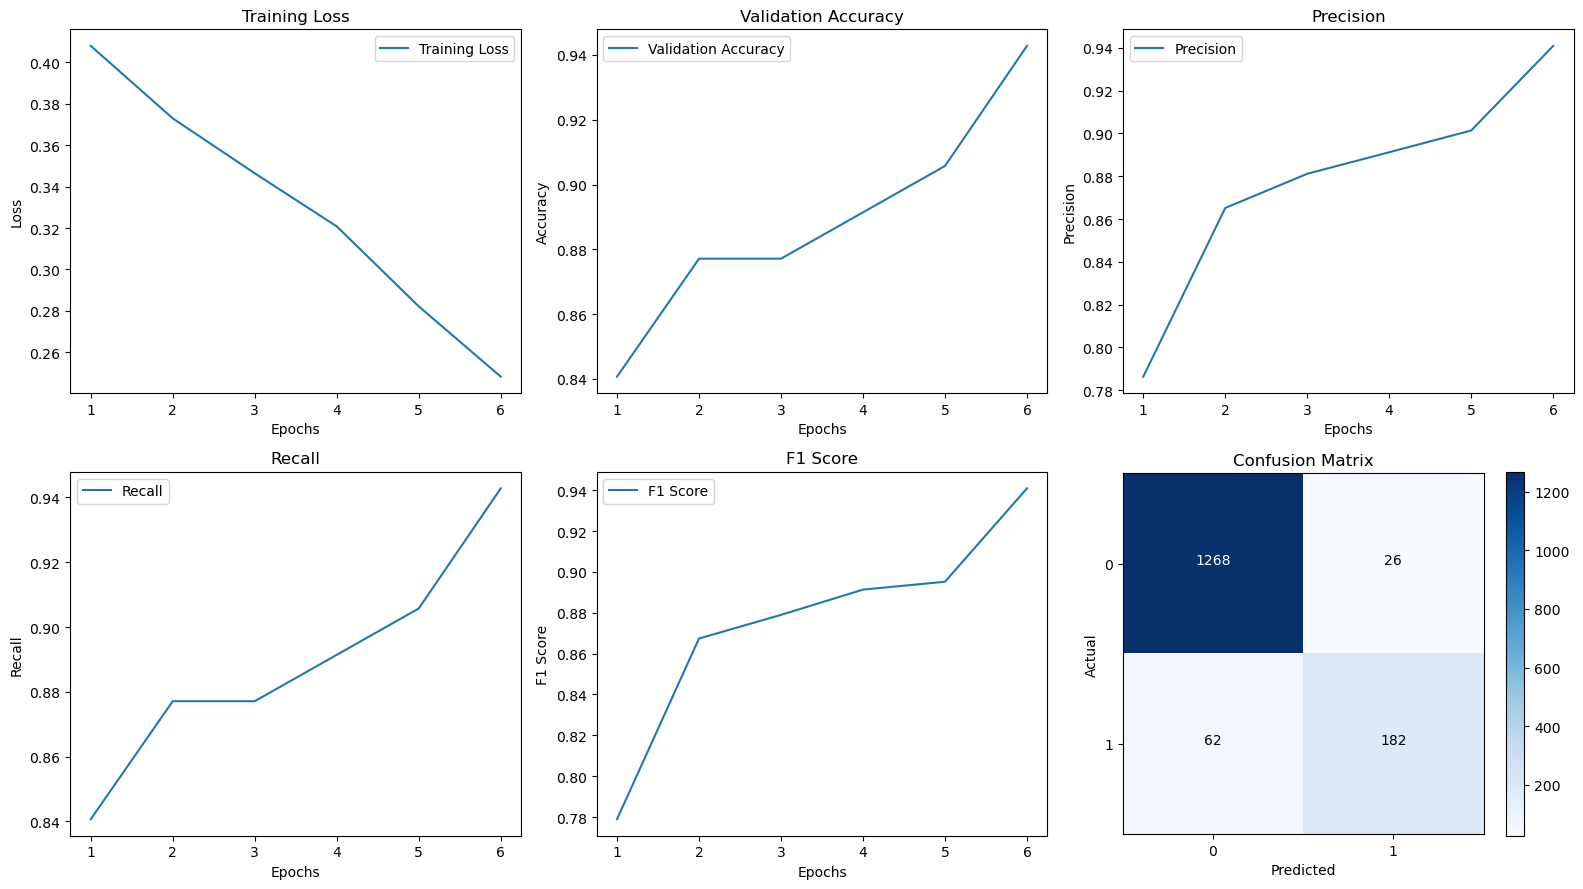

In [23]:
trainer.plot_metrics()

In [24]:
# test model with test data
trainer.test(test_loader)

Test Accuracy: 0.8971
Test Precision: 0.9105
Test Recall: 0.8971
Test F1 Score: 0.9017
Confusion Matrix:
[[2520  238]
 [ 100  426]]
